[Masuda et al. (2017)](https://doi.org/10.1016/j.biortech.2017.04.110) introduced _mvaE_ and _mvaS_ into _E. coli_ to produce mevalonate.
They observed that sulfur starvation increased mevalonate yield significantly (close to the theoretical maximum).
Mevalonate production could therefore be carried out efficiently with a fed-batch process with a sulfur-starved production stage (which can be optimized using our web tool).
We use data extracted from Fig. 1 of their publication to illustrate how the product formation rates required for our web tool can be estimated.

One thing to note is that Fig. 1a in [Masuda et al. (2017)](https://doi.org/10.1016/j.biortech.2017.04.110) contains biomass and mevalonate concentrations over time during exponential growth with a more or less constant specific growth rate.
Fig. 1d contains concentration profiles during sulfur starvation (with no growth).
Therefore, we cannot disentangle growth-decoupled production ($\pi_0$) and growth-associated production ($\pi_1$) during the growth stage (as we would need a change in growth rate for that).
However, since $dP/dt = X (\pi_0 + \mu \pi_1)$, we don't need to know $\pi_0$ and $\pi_1$ separately to simulate a process with exponential growth, because then $\mu = const$ and $\pi = \pi_0 + \mu \pi_1 = const$.

Thus, we only need to estimate the total product formation rate $\pi$ from Fig. 1a (which we will set equal to $\pi_0$) in order to determine product formation during the growth stage.
Further, during the growth-arrested production stage, $\mu = 0$ and we can ignore $\pi_1$.

We therefore have to estimate only two parameters:

- $\pi$ during the growth stage (`pi_s1` below): for this we consider the time points between 4 (induction with IPTG) and 8 hours (glucose depletion) in Fig 1a.
- $\pi_0$ during the production stage (`pi_s2` below): for this we consider the first 4 hours in Fig 1d (i.e. before glucose depletion).


In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

sys.path.append("../..")
from params import defaults_E_coli

# first, let's define some parameters and parse the data
glc_MW = 180.16  # g/mol
mevalonate_MW = 147.15  # g/mol
mu = 0.48  # /h (reported in the paper)
OD_to_x = 0.3  # OD600 to g/L

# read data for Fig. 1a
df_s1_orig = pd.read_csv("fig-1a.csv", index_col=0)
# only keep samples between t=4 (induction with IPTG) and t=8 (glucose depletion) and
# convert OD and mM to g/L
df_s1 = pd.DataFrame(
    {
        "x": df_s1_orig["OD600"] * OD_to_x,
        "p": df_s1_orig["mevalonate [mM]"] * 1e-3 * 147.15,
    }
).loc[4:8]

# read data for Fig. 1d
df_s2_orig = pd.read_csv("fig-1d.csv", index_col=0)
# only keep samples up to t=4 (glucose depletion) and convert mM to g/L
df_s2 = pd.DataFrame(
    {
        "x": df_s2_orig["OD600"] * OD_to_x,
        "p": df_s2_orig["mevalonate [mM]"] * 1e-3 * mevalonate_MW,
        "glc": df_s2_orig["glucose [mM]"] * 1e-3 * glc_MW,
    }
).loc[:4]

Let's have a look at the concentration profiles of the growth and starvation stages.

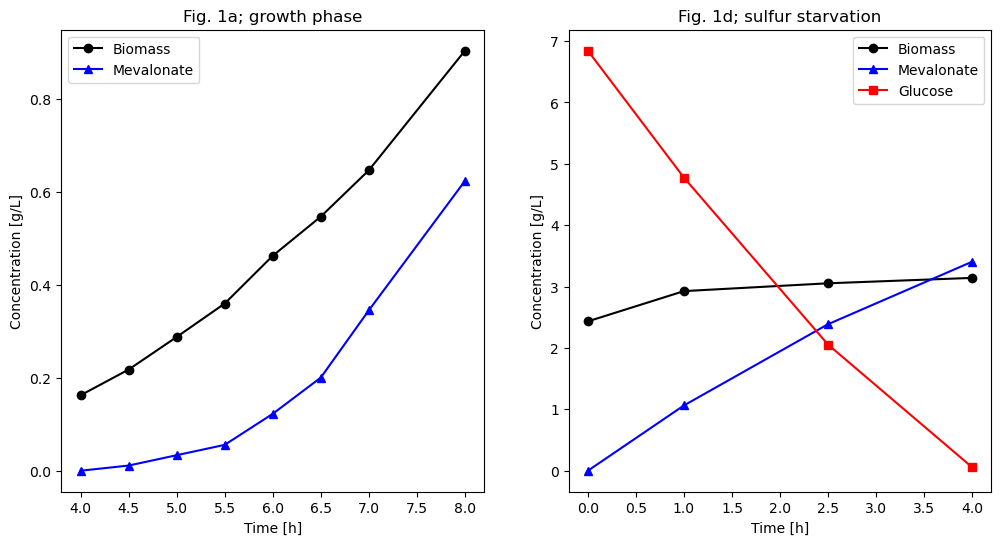

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(df_s1["x"], "ko-", label="Biomass")
ax1.plot(df_s1["p"], "b^-", label="Mevalonate")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Concentration [g/L]")
ax1.set_title("Fig. 1a; growth phase")
ax1.legend()

ax2.plot(df_s2["x"], "ko-", label="Biomass")
ax2.plot(df_s2["p"], "b^-", label="Mevalonate")
ax2.plot(df_s2["glc"], "rs-", label="Glucose")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Concentration [g/L]")
ax2.set_title("Fig. 1d; sulfur starvation")
ax2.legend()
plt.show()

Now let's fit the data to estimate $\pi$ during the growth phase (i.e. the combined product formation rate containing growth-associated and growth-decoupled production).

In [3]:
x0 = df_s1["x"].iloc[0]
# the time to consider in the fit is from 4 to 8 hours but in terms of exponential
# growth, we need to start at t=0
t_s1 = df_s1.index.values - 4
y_true = df_s1.values


def predict_1a(x0, pi, t=t_s1):
    """
    Predict the biomass and mevalonate concentration at time t given initial biomass and
    production rate
    """

    def ODEs(t, y):
        x, p = y
        dxdt = mu * x
        dpdt = pi * x
        return [dxdt, dpdt]

    sol = solve_ivp(fun=ODEs, t_span=[0, t[-1]], y0=[x0, 0], t_eval=t)

    return pd.DataFrame(sol.y.T, index=t, columns=["x", "p"])


def get_residuals(params_to_fit):
    pred = predict_1a(*params_to_fit)
    return (pred.values - y_true).ravel()


x0_s1_fit, pi_s1_fit = least_squares(get_residuals, [df_s1["x"].iloc[0], 0.1]).x
print(f"{x0_s1_fit=:.3g} g/L, {pi_s1_fit=:.3g} /h")

x0_s1_fit=0.148 g/L, pi_s1_fit=0.331 /h


Let's have a look at the fit!

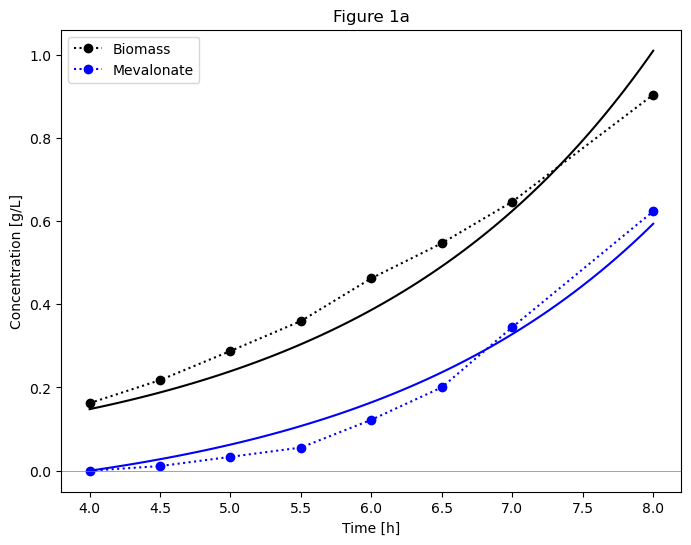

In [4]:
pred = predict_1a(x0_s1_fit, pi_s1_fit, np.linspace(t_s1[0], t_s1[-1], 100))
pred.index += 4

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df_s1["x"], "ko:", label="Biomass")
ax.plot(df_s1["p"], "bo:", label="Mevalonate")
ax.plot(pred["x"], "k-")
ax.plot(pred["p"], "b-")
ax.axhline(0, color="gray", lw=0.5)
ax.legend()
ax.set_xlabel("Time [h]")
ax.set_ylabel("Concentration [g/L]")
ax.set_title("Figure 1a")
plt.show()

This doesn't look perfect (biomass doesn't seem to follow strict exponential growth and might also have grown at a slightly lower rate than reported in the paper).
However, for our purposes it should be good enough.

Now let's use the data from Fig. 1d to estimate $\pi_0$ during the production stage (i.e. under sulfur starvation).

In Fig. 1d biomass is more or less constant. We're thus going to make life easy for ourselves and just take the mean biomass and the final product concentration to calculate the product formation rate.
Glucose is depleted after 4 hours so we'll ignore the later time points.

In [5]:
x_s2_integral = df_s2["x"].mean() * df_s2.index[-1]
pi_s2 = df_s2["p"].iloc[-1] / x_s2_integral
print(f"Production rate in stage 2:\t{pi_s2:.3f} /h")

Production rate in stage 2:	0.295 /h


Lastly, let's calculate the true product yield (i.e. taking maintenance into account) during sulfur starvation with respect to the amount of glucose consumed.
This should be close to the theoretical maximum of 2/3 mol mevalonate per mol glucose.

In [6]:
Yxs = defaults_E_coli["s1_Y_XS"]
Yas = defaults_E_coli["s1_Y_AS"]
rho = defaults_E_coli["s1_rho"]
consumed_glucose = df_s2["glc"].iloc[0] - df_s2["glc"].iloc[-1]

glc_for_maint = x_s2_integral * rho / Yas
glc_for_prod = consumed_glucose - glc_for_maint
Yps = df_s2["p"].iloc[-1] / glc_for_prod
print(f"Glucose used for maintenance:\t{glc_for_maint:.3f} g/L")
print(f"Glucose used for product:\t{glc_for_prod:.3f} g/L")
print(f"Product-substrate yield:\t{Yps:.3f} g/g")
theoretical_Yps = 2 / 3 * mevalonate_MW / glc_MW
print(f"Maxmium theoretical yield:\t{theoretical_Yps:.3f} g/g")

print(f"deviation:\t\t\t{(Yps - theoretical_Yps) / theoretical_Yps:.1%}")

Glucose used for maintenance:	0.682 g/L
Glucose used for product:	6.106 g/L
Product-substrate yield:	0.558 g/g
Maxmium theoretical yield:	0.545 g/g
deviation:			2.4%


Indeed the product yield we got is within 3% of the expected value.